In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# STO production data

## Step 1:  Python Code for Data Reading

In [87]:
# Specify the working directory 
new_directory = r"C:\Users\niels\Documents\Exercises\02 model_production_process\data\daily_production\STO"

# Specify the relative path to the directory containing the JSON files
relative_directory_path = new_directory

# Get a list of file names in the specified directory
file_names = os.listdir(relative_directory_path)

# Use os.path.join to build the relative file paths
STO_files_relative = [os.path.join(relative_directory_path, file_name) for file_name in file_names 
                      if file_name.endswith(".json")]

#Combine jsons in one dataframe
dfs = []

for file_path in STO_files_relative:
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        df_temp = pd.json_normalize(json_data)  
        dfs.append(df_temp)

dfSTO= pd.concat(dfs, ignore_index=True)


In [88]:
dfSTO

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Monday,1,0,01-01-2018 00:00:00.0000,No,9,3,265
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,9,3,265
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,18,6,256
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,22,8,252
4,Friday,1,0,01-05-2018 00:00:00.0000,No,31,11,243
...,...,...,...,...,...,...,...,...
1825,Saturday,1,0,12-31-2022 00:00:00.0000,No,51,19,223
1826,Sunday,1,0,01-01-2023 00:00:00.0000,No,53,20,221
1827,Monday,1,0,01-02-2023 00:00:00.0000,No,61,22,213
1828,Tuesday,1,0,01-03-2023 00:00:00.0000,No,70,25,204


## Step 2: data exploration

In [122]:
# Summarize unique values for all columns
unique_values_summary = {}

for column in dfSTO.columns:
    unique_values_summary[column] = dfSTO[column].unique()

for column, unique_values in unique_values_summary.items():
    print(f"Unique values for {column}: {unique_values}")

Unique values for DoW: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Unique values for hour: [1]
Unique values for minute: [0]
Unique values for date: ['01-01-2018 00:00:00.0000' '01-02-2018 00:00:00.0000'
 '01-03-2018 00:00:00.0000' ... '01-02-2023 00:00:00.0000'
 '01-03-2023 00:00:00.0000' '01-04-2023 00:00:00.0000']
Unique values for maintenance: ['No' 'Yes']
Unique values for prod_loss: [9 18 22 31 38 52 46 41 48 44 56 53 49 45 60 54 57 51 47 58 61 55 50 43 67
 73 62 65 72 75 70 69 74 68 71 78 66 59 87 81 79 83 88 84 82 77 86 89 80
 64 95 90 97 94 99 92 85 63 76 274 249 236 211 195 175 159 149 148 136 140
 260 240 223 '#MV' 229 189 184 170 158 151 143 131 124 118 106 107 100 40
 37 36 42 96 103 108 116 109 102 91 98 244 227 206 201 183 168 162 146 235
 200 185 172 153 129 110 247 174 254 253 225 202 180 163 154 126 115 39
 251 222 193 156 139 133 120 114 104 101 248 232 213 186 179 160 123 128
 119 113 117 250 220 212 182 164 145 134 93 233 221 199 190 20

In [203]:
dfSTO['maintenance'].value_counts()

prod_loss
274    126
#MV    114
72      55
76      51
71      50
      ... 
164      1
240      1
129      1
233      1
122      1
Name: count, Length: 195, dtype: int64

In [116]:
dfSTO['prod_loss'].value_counts()

prod_loss
274    126
#MV    114
72      55
76      51
71      50
      ... 
164      1
240      1
129      1
233      1
122      1
Name: count, Length: 195, dtype: int64

In [117]:
#Explore if #MV and planned maintenance is correlated
dfSTO.loc[945,:]

DoW                                 Monday
hour                                     1
minute                                   0
date              08-03-2020 00:00:00.0000
maintenance                            Yes
prod_loss                              #MV
prod_loss_perc                         #MV
production                             NaN
Name: 945, dtype: object

### Visual data exploration production data

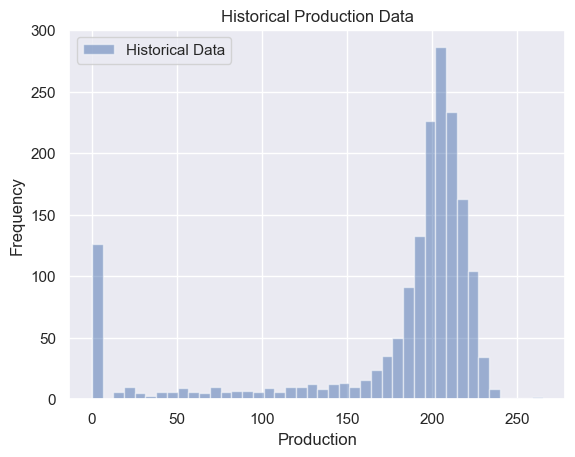

In [100]:
#Remove non-numerical values with Nan
STO_production = pd.to_numeric(dfSTO['production'], errors='coerce')

# Determine optimal numbers of bins for histogram
num_bins = int(np.sqrt(len(STO_production)))

# Plot historical data
plt.hist(STO_production, bins=num_bins, alpha=0.5, label='Historical Data')
plt.legend()
plt.title('Historical Production Data')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.show()

## Step 3: Data filtering for further analysis

In [222]:
# Filter out the plannend maintenance and zero production days
dfSTO_prod = dfSTO.loc[(dfSTO['maintenance'] == 'No') & (dfSTO['prod_loss_perc'] != 100), :]

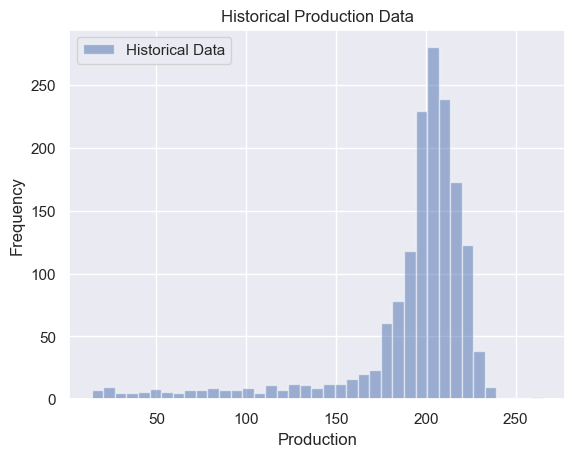

In [223]:
num_bins = int(np.sqrt(len(dfSTO_prod)))

# Plot historical data
plt.hist(dfSTO_prod['production'], bins=num_bins, alpha=0.5, label='Historical Data')
plt.legend()
plt.title('Historical Production Data')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.show()

## Step 4: Identify Suitable Distribution for Production Process

In [204]:
#Remove non-numerical values with Nan
dfSTO_prod_exzero = pd.to_numeric(dfSTO_prod['production'], errors='coerce')

dfSTO_prod_exzero.dtype

dtype('int64')

In [224]:
import numpy as np
from scipy import stats

def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution (scipy.stats.rv_continuous): The best-fit distribution.
        best_params (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,      # Normal distribution
            stats.gamma,     # Gamma distribution
            stats.expon,     # Exponential distribution
            stats.uniform    # Uniform distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def main():
  
    # Find the best-fit distribution
    best_distribution, best_params = find_best_fit_distribution_continuous(dfSTO_prod_exzero)

    # Print the best-fit distribution and its parameters
    print(f"Best-fit distribution: {best_distribution.name}")
    print(f"Parameters: {best_params}")

if __name__ == '__main__':
    main()



Best-fit distribution: norm
Parameters: (190.9679245283019, 40.17786996986101)


In [225]:
sto_best_distribution, sto_best_params = find_best_fit_distribution_continuous(dfSTO_prod_exzero)

## Step 6: Develop Simulation Program

In [213]:
n_days = int(input("Enter the number of days for simulation:"))

def simulation(n_days, N, df_best_params):
    
    parameter_list=list(df_best_params)
    mean = parameter_list[0]
    std_dev = parameter_list[1]
    
    random_numbers = np.random.normal(mean, std_dev, size=(n_days, N))
    
    tot_prod = random_numbers.sum(axis=0)
       
    return tot_prod

# variables simulation function
N = 10**4

STO_data = simulation(n_days, N, sto_best_params)

Enter the number of days for simulation:5


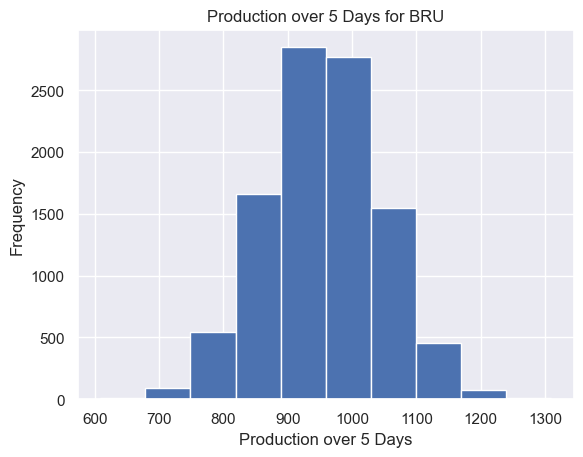

,production_of_5_days
count,10000.000000
mean,955.479616
std,89.524239
min,608.523487
25%,894.466243
50%,955.439901
75%,1017.017680
max,1309.688173


In [214]:
# Create dataframe from simulation data
df_STO_prod = pd.DataFrame(STO_data, columns=[f'production_of_{n_days}_days'])

# Visualize the simulation data
plt.hist(df_STO_prod[f'production_of_{n_days}_days'])
plt.title(f'Production over {n_days} Days for BRU')
plt.xlabel(f'Production over {n_days} Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualize the summary of the simulation data

display(df_STO_prod.describe())

## Step 7: Visualize cumulative distribution function

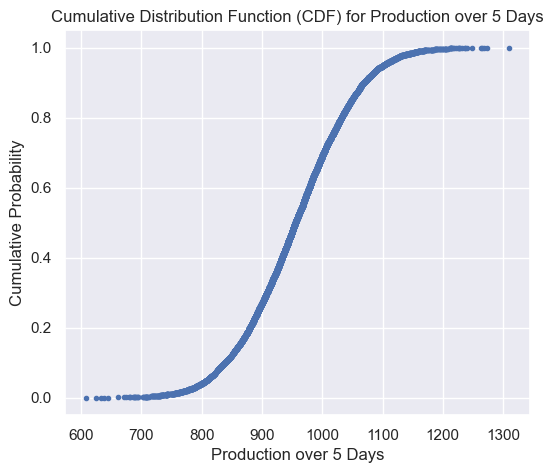

In [220]:
#function to determine the cumulative distribution function
def plot_cdf(data):
    xx= np.sort(data)
    n = len(data)
    Fxx = np.arange(1, n + 1) / n
    
    return xx, Fxx

xx, Fxx = plot_cdf(STO_data)

#plot the cdf
plt.figure(figsize=(6,5))
plt.plot(xx, Fxx, marker=".", linestyle="none")
plt.title(f"Cumulative Distribution Function (CDF) for Production over {n_days} Days")
plt.xlabel(f"Production over {n_days} Days")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()